<center>
    <h1>
Selectivity estimation for DBSM
    </h1>
</center>

<center>
Alejando de la Concha Duarte
</center>

In database system management (DBSM), every request formulated by a user can be viewed as an event in a probability space $( Ω, T , P)$ where $ Ω$ is a finite set having $N$ elements. In oder to optimize request fulfillment, it is useful to estimate accurately the probabilities (also called selectivities) associated with the elements of Ω. To do so, rough estimations of the probabilities of a certain number M of events are available. (These estimations are performed based on a history of formulated requests and some a priori knowledge.)

Let $x \in \mathbb{R}^N$ be the vector of sought probabilities and let $b = (b^{(i)})_{1≤i≤M} \in ]0, 1]^M$
be the vector of estimated probabilities. The problem is equivalent to:

$$ minimize_{x∈C} q_b(Ax)  \ \ \ (1)$$
where

– $C = \{x = (x^{(i)})_{1≤i≤N} ∈ [0, 1]^N |\sum_{i=1}^N x^{(i)} = 1\} $;

– $A ∈ \{0, 1\}^{MxN}$ is a binary matrix establishing the theoretical link existing
between the probabilities of each event and the probabilities of the elements
of $Ω$ belonging to it ;

– $q_b$ is the quotient function defined as

$$∀y = (y^{(i)})_{1≤i≤M} ∈ \mathbb{R}^M \ \ q_b(y) = \sum_{i=1}^M θ(y^{(i)}/b^{(i)})$$

with 

$$\theta(\epsilon)=\begin{cases} \epsilon \ \ \text{if} \ \ \epsilon \geq 1 \\ \epsilon^{-1} \ \ \text{if} \ \ 0<\epsilon<1 \\ +\infty \ \ \text{otherwise} \end{cases}$$

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import copy

## Question 1

Is the quotien function convex? lower-semicontinuous?

In [183]:
def theta(eps):
    if eps>=1:
        return(eps)
    if eps>0 and eps<=1:
        return(1/eps)
    else:
        return(np.infty)
v_theta=np.vectorize(theta)
def quotient(y,b):
    return sum(v_theta(y/b))

Text(0.5, 1.0, 'Theta function')

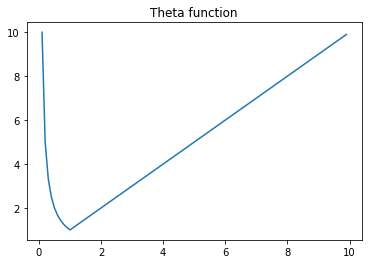

In [184]:
x=np.arange(1e-1,10,0.1)
y=v_theta(x)
plt.plot(x,y)
plt.title("Theta function")

It is easy to see that the epigraph of the $\theta$ function is convex and as a consequence it is convex. As the quotien function is the sum of convex functions, it is convex too. Similarly, we can show that the quotient function is a sum of continuos functions,so it is continuos.

## Question 2

Does there exist a solution to Problem (1) ?

It exist since $C$ is a compact set and $q(A(.))$ is a continuos function. 

## Question 3

Let $\gamma \in (0,+\infty)$. It can be proved that:
$$\forall \epsilon \in \mathbb{R} \ \ prox_{\gamma\theta}(\epsilon)=\begin{cases} \psi \ \ \text{if} \ \ \epsilon<1-\gamma \\ 1 \ \ \text{if} \ \ \epsilon \in [1-\gamma,1+\gamma] \\ \epsilon-\gamma \ \ \text{if} \ \ \epsilon>1+\gamma \end{cases}$$

where $\psi$ is the unique solution in $(0,1]$ of the cubic equation :
                                         
$$\psi^3-\epsilon\psi^2=\gamma$$
Deduce the expression of the proximal operator of $\gamma q_b$, for every $b \in (0,1)^M$.  

$proximity_{\gamma \theta}(\epsilon)=argmin_y \gamma \theta(y) + \frac{(y-\epsilon)^2}{2}$

If we check what would happen in $y>1$, we would have:

\begin{aligned}
f(y)=y+\frac{(y-\epsilon)^2}{2} \\
\Delta_y f(y)= \gamma+(y-\epsilon)  \\
\end{aligned}
that would imply that $\hat{y}=\epsilon-\gamma$ , given the hypothesis it is necessary that $\epsilon>1+\gamma$

It this is no the case, that is $\epsilon \leq 1+-\gamma$, we would have that: $\Delta_y f(y)>0$ , meaning that the function is increasing in $(1,\infty)$ , then $\hat{y}=1$.


If $0<y<1$ 
\begin{aligned}
f(y)=\frac{\gamma}{y}+\frac{(y-\epsilon)^2}{2} \\
\Delta_y f(y)=\frac{-\gamma}{y^2}+(y-\epsilon)
\end{aligned}

Then $\hat{y}$ is the solution to the third degree equation:
$$\hat{y}^3-\epsilon \hat{y}^2=\gamma$$

As $y<1$ that would imply that:
\begin{aligned}
1-\epsilon y^2 > y^3-\epsilon y^2 =\gamma \\
\text{then} \\
1-\epsilon y^2 > \gamma \ \ \text{so}  \ \ 1-\gamma>\epsilon
\end{aligned}

If $\epsilon>1-\gamma$ we would have that $\Delta_y f(y)<(y-1)+\gamma(1-\frac{1}{y^2})<0$, meaning that $\hat{y}=1$

Thus we have the result of the statement.

Given the properties of the proximity operator we would have that $proximity_{q_b}(x)=\{\frac{prox_{b_i^2 \theta}(b_i x_i)}{b_i}\}_{i \in \{1,..M\}}$

## Question 4

Write a function for computing this operator.

In [249]:
def theta_proximity(gamma,x):
    if x<1-gamma:
        roots=np.roots([1,-x,0,-gamma])
        index=np.where((roots>0)*(roots<=1)*(np.imag(roots)==0.))[0]
        return(np.real(roots[index]))
    if x>1+gamma:
        return x-gamma
    else:
        return 1.

def proximity(x,b):
    N=len(x)
    result=np.zeros(N)
    for i in range(N):
        result[i]=theta_proximity(x=(1/b[i])*x[i],gamma=(1/(b[i]**2)))*b[i]
    return result

## Question 5

Propose a primal-dual algorithm to solve Problem (1).
(A code is provided implementing the projection onto C.)

In [1]:
################## Proyection onto a simplex.
## Original code: http://www.mcduplessis.com/index.php/2016/08/22/fast-projection-onto-a-simplex-python/
def bisectsearch(d,evalpL):
        idxL, idxH = 0, d-1
        L = evalpL(idxL)
        H = evalpL(idxH)
 
        if L<0:
            return idxL
 
        while (idxH-idxL)>1:
            iMid = int((idxL+idxH)/2)
            M = evalpL(iMid)
 
            if M>0:
                idxL, L = iMid, M
            else:
                idxH, H = iMid, M
 
        return idxH

def proj(y):
    a=np.ones(len(y))
    l = y/a
    idx = np.argsort(l)
    d = len(l)
 
    evalpL = lambda k: np.sum(a[idx[k:]]*(y[idx[k:]] - l[idx[k]]*a[idx[k:]]) ) -1

 
    k = bisectsearch(d,evalpL)
    lam = (np.sum(a[idx[k:]]*y[idx[k:]])-1)/np.sum(a[idx[k:]])
 
    x = np.maximum(0, y-lam*a)
 
    return x

In [2]:
def Dual_primal(A,b,tol=1e-6):
    ##### Algorithm performing a DUal Primal algorithm
    ## Input
    # A: matrix linking probabilities x and b
    # b: probabilities related with observed events.
    ## Output
    # x: solution of the primal.
    sigma=1.
    tau=1/(2*sigma*(np.linalg.norm(A,ord=2)**2))
    N=A.shape[0]
    M=A.shape[1]
    #### Initialization.
    x_old=np.zeros(M)
    v_old=np.zeros(N)
    x_new=proj(x_old-tau*(A.transpose().dot(v_old)))
    v_new=v_old+sigma*(A.dot(2*x_new-x_old))-proximity(v_old+sigma*(A.dot(2*x_new-x_old)),b)
    while((np.sqrt(np.sum((x_old-x_new)**2))>tol)*(np.sqrt(np.sum((v_old-v_new)**2))>tol)):
        x_old=copy.deepcopy(x_new)
        v_old=copy.deepcopy(v_new)
        ### Proximity of the indicator function over the set C.
        x_new=proj(x_old-tau*(A.transpose().dot(v_old)))
        ### Proximity operator of the conjugate of the quotient function.
        v_new=v_old+sigma*(A.dot(2*x_new-x_old))-proximity(v_old+sigma*(A.dot(2*x_new-x_old)),b)
    return(x_new)  

## Question 6

Apply the algorithm to the following example :

In [261]:
b=np.array([0.2114,0.6331,0.6312,0.5182,0.9337,0.0035])

In [262]:
A=[1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1]
A=np.array(A).reshape((6,7))

In [263]:
x=Dual_primal(A,b,tol=1e-8)

In [264]:
x

array([0.        , 0.17114697, 0.32748023, 0.05709316, 0.44078003,
       0.        , 0.00349961])

## Question 7

Would it be possible to apply ADMM on this example ?

It is not possible as ADMM requires $A^*A$ to be an isomorphism, but the rank of this product is 6 not 7, so the transformation is not biyective.

In [204]:
np.linalg.matrix_rank(A.transpose().dot(A))

6